In [1]:
import pandas
import datetime
import feather
import numpy
import scipy.optimize
from aacgmv2 import convert_mlt
import seaborn as sns
from davitpy import utils
from imagers.ssusi import ssusi_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter
from aacgmv2 import convert_mlt, convert
from pyigrf12 import gridigrf12
%matplotlib inline

In [2]:
# Some constants
eventDate = datetime.datetime(2015,2,2)
timeStart = datetime.datetime(2015,2,2,3,0)
timeEnd = datetime.datetime(2015,2,2,7,0)
sapsTime = datetime.datetime(2015,2,2,5,0)
velMagnScale = [ 0, 1000 ]
coords="mlt"
pltCoords = "mlt"
delLatDist = 111. * 1e3 # 1 deg lat is 111 km
cntrPotMin = -35.
cntrPotMax = 5.
cntrLevels = numpy.linspace(cntrPotMin, cntrPotMax, 9, endpoint=True)

In [3]:
def round2(number):
    """
    Round a number to the closest half integer.
    """
    return round(number * 2) / 2

def get_west_vel(row):
    westVel = row['vLos']/( numpy.cos(\
                 numpy.deg2rad( 90.-\
                    row['azimCalcMag'] ) ) )
    if westVel >= 2000.:
        return numpy.nan
    return westVel


def convert_to_datetime(row):
    currDateStr = str( int( row["dateStr"] ) )
#     return currDateStr
    if row["timeStr"] < 10:
        currTimeStr = "000" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 100:
        currTimeStr = "00" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 1000:
        currTimeStr = "0" + str( int( row["timeStr"] ) )
    else:
        currTimeStr = str( int( row["timeStr"] ) )
    return datetime.datetime.strptime( currDateStr\
                    + ":" + currTimeStr, "%Y%m%d:%H%M" )


def get_mlon_from_mlt(row):
    if row["normMlt"] < 0: 
        currMLT = row["normMlt"] + 24.
    else:
        currMLT = row["normMlt"]
    if row["endPtnormMlt"] < 0: 
        currEndptMLT = row["endPtnormMlt"] + 24.
    else:
        currEndptMLT = row["endPtnormMlt"]
    row["Mlon"] = numpy.round( \
                        convert_mlt( currMLT, row["date"] , m2a=True ) )
    if row["Mlon"] > 180.:
        row["Mlon"] -= 360.
    row["EndptMlon"] = numpy.round( \
                        convert_mlt( currEndptMLT, row["date"] , m2a=True ) )
    if row["EndptMlon"] > 180.:
        row["EndptMlon"] -= 360.
    return row

def get_geo_coords(row):
    if row["normMlt"] < 0: 
        currMLT = row["normMlt"] + 24.
    else:
        currMLT = row["normMlt"]
    currMlon = convert_mlt( currMLT, row["date"] , m2a=True )
    glat, glon = convert( row["mlat"], currMlon , 300, row["date"], a2g=True)
    return str(glat) + "__" + str(glon)

def get_efield(row):
    Bx,By,Bz,Bf, yeardec = gridigrf12( row["date"], 0, 1, 300., row["glat"], row["glon"] )
    Vy = row["velSAPS"] * numpy.round( numpy.sin(numpy.deg2rad( row["azimSAPS"] )), 2 )
    Vx = row["velSAPS"] * numpy.round( numpy.cos(numpy.deg2rad( row["azimSAPS"] )), 2 )
    Vz = 0.
    Ex = Bz[0] * -1 * Vy * 1e-9 # nT
    Ey = Bz[0] * Vx * 1e-9 # nT
    Ez = Bx[0] * Vy * 1e-9 - By[0] * Vx * 1e-9 # nT
    # Round electric fields by 2
    Ex = numpy.round( Ex * 1e3 , 4 ) # mV/m
    Ey = numpy.round( Ey * 1e3 , 4 ) # mV/m
    Ez = numpy.round( Ez * 1e3 , 4 ) # mV/m
    return str(Ex) + "__" + str(Ey) + "__" + str(Ez)

In [4]:
# read from the feather file
lshellDF = feather.read_dataframe('../data/lshellFits-' +\
                eventDate.strftime("%Y%m%d") + '.feather')
lshellDF.head()

,azimSAPS,azimSTD,delMLT,goodFit,mlat,normMlt,velSAPS,velSTD,endPtMLAT,endPtNormMLT,date
0,-8.183222,7.139045,1.5,1,64.5,-6.0,344.175702,38.209791,64.55,-6.34,2015-02-02 01:10:00
1,0.061671,1.587688,1.0,1,65.5,-5.0,395.874051,17.983572,65.50,-5.40,2015-02-02 01:10:00
2,-18.972847,9.009681,1.0,1,63.5,-6.0,363.200633,39.581690,63.62,-6.34,2015-02-02 01:10:00
3,-9.904435,5.503352,1.5,1,65.0,-6.0,338.319421,32.269812,65.06,-6.33,2015-02-02 01:10:00
4,-15.363696,9.569517,0.5,1,64.0,-6.0,393.615604,42.954980,64.10,-6.38,2015-02-02 01:10:00


In [5]:
lshellDF["endPtmlat"] = numpy.round( (lshellDF["velSAPS"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*lshellDF["azimSAPS"]) ) +\
                                lshellDF["mlat"], 2)
lshellDF["endPtnormMlt"] = numpy.round( (lshellDF["velSAPS"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*lshellDF["azimSAPS"]) ) +\
                                lshellDF["normMlt"], 2)
lshellDF = lshellDF.apply( get_mlon_from_mlt, axis=1 )

lshellDF.head()

,azimSAPS,azimSTD,delMLT,goodFit,mlat,normMlt,velSAPS,velSTD,endPtMLAT,endPtNormMLT,date,endPtmlat,endPtnormMlt,Mlon,EndptMlon
0,-8.183222,7.139045,1.5,1,64.5,-6.0,344.175702,38.209791,64.55,-6.34,2015-02-02 01:10:00,64.55,-6.34,-29.0,-34.0
1,0.061671,1.587688,1.0,1,65.5,-5.0,395.874051,17.983572,65.50,-5.40,2015-02-02 01:10:00,65.50,-5.40,-14.0,-20.0
2,-18.972847,9.009681,1.0,1,63.5,-6.0,363.200633,39.581690,63.62,-6.34,2015-02-02 01:10:00,63.62,-6.34,-29.0,-34.0
3,-9.904435,5.503352,1.5,1,65.0,-6.0,338.319421,32.269812,65.06,-6.33,2015-02-02 01:10:00,65.06,-6.33,-29.0,-33.0
4,-15.363696,9.569517,0.5,1,64.0,-6.0,393.615604,42.954980,64.10,-6.38,2015-02-02 01:10:00,64.10,-6.38,-29.0,-34.0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


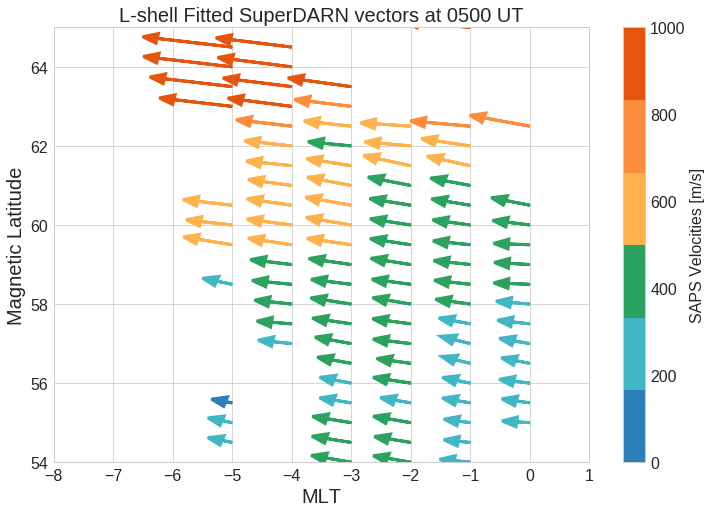

In [6]:
selTime = sapsTime#datetime.datetime(2016,7,25,5,30)
selSapsDF = lshellDF[ lshellDF["date"] == selTime ]
selSapsDF["SAPS speed [m/s]"] = selSapsDF["velSAPS"]
plotMLTends = selSapsDF['endPtnormMlt'].tolist()
plotmlatends = selSapsDF['endPtmlat'].tolist()
plotMLTbegins = selSapsDF['normMlt'].tolist()
plotmlatbegins = selSapsDF['mlat'].tolist()
plotVelMagns = selSapsDF['SAPS speed [m/s]'].tolist()


# Seaborn styling# OrRd
sns.set_style("whitegrid")
sns.set_context("paper")
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]
seaMap = ListedColormap(sns.color_palette(colors))
# lshlPlt = selSapsDF.plot( kind='scatter',
#               x='Mlon',
#               y='mlat',
#               c='SAPS speed [m/s]',
#               s=1., cmap=seaMap, vmin=velMagnScale[0],\
#               vmax=velMagnScale[1], ax=ax,fontsize=20)
lshellPlot = ax.scatter( x=selSapsDF["normMlt"], y=selSapsDF["mlat"],\
                     c=selSapsDF["SAPS speed [m/s]"],cmap=seaMap,\
                     vmin=velMagnScale[0],vmax=velMagnScale[1], s=1 )

colNorm = Normalize( vmin=velMagnScale[0], vmax=velMagnScale[1] )
for currMLTend, currmlatend, currMLTbgn, currmlatbgn, currVel in\
        zip( plotMLTends, plotmlatends, plotMLTbegins, plotmlatbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
#         ax.plot( [currMLTbgn, currMLTend], [ currmlatbgn, currmlatend ], color=currCol )        
        ax.arrow( currMLTbgn, currmlatbgn, currMLTend-currMLTbgn, currmlatend-currmlatbgn,\
                 head_width=0.25, head_length=0.25, fc=currCol, ec=currCol, lw=3.)
    
ax.set_xlim( [-8,1] )
ax.set_ylim( [ 54., 65. ] )
ax.set_ylabel( "Magnetic Latitude", fontsize=20 )
ax.set_xlabel( "MLT", fontsize=20 )
ax.set_title("L-shell Fitted SuperDARN vectors at " +\
             selTime.strftime("%H%M") + " UT", fontsize=20)

ax.tick_params(labelsize=16)
cb = plt.colorbar(lshellPlot, ax=ax, cmap=seaMap)
cb.ax.tick_params(labelsize=16)
cb.ax.set_ylabel('SAPS Velocities [m/s]', fontsize=16)
# cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
# fig.colorbar(lshellPlot, cax=cax, orientation='horizontal')

In [7]:
lshellDF["gcoord"] = lshellDF.apply( get_geo_coords, axis=1 )
lshellDF["glat"] = [ float( x.split("__")[0] ) for x in lshellDF["gcoord"] ]
lshellDF["glon"] = [ float( x.split("__")[1] ) for x in lshellDF["gcoord"] ]

In [8]:
lshellDF["Efield"] = lshellDF.apply( get_efield, axis=1 )
lshellDF["Ex"] = [ float( x.split("__")[0] ) for x in lshellDF["Efield"] ]
lshellDF["Ey"] = [ float( x.split("__")[1] ) for x in lshellDF["Efield"] ]
lshellDF["Ez"] = [ float( x.split("__")[2] ) for x in lshellDF["Efield"] ]
lshellDF["Efield"] = numpy.sqrt( numpy.square(lshellDF["Ex"]) +\
                                 numpy.square(lshellDF["Ey"]) +\
                                 numpy.square(lshellDF["Ez"]))

In [9]:
selTimeLshellDF = lshellDF[ lshellDF["date"] == sapsTime ]
mltVelsVarsDF = selTimeLshellDF[ ["normMlt", "mlat", "velSAPS", "Efield"] \
                    ].groupby( ["normMlt", "mlat"] ).mean().reset_index()

mltVelsVarsDF.columns = ["normMlt", "mlat", "mean_vel", "mean_efld"]
# stdVelsVarsDF = selTimeLshellDF[ ["normMlt", "mlat", "velSAPS", "Efield"] \
#                     ].groupby( ["normMlt", "mlat"] ).std().reset_index()
# stdVelsVarsDF.columns = ["normMlt", "mlat", "std_vel", "std_efld"]
# print stdVelsVarsDF
# mltVelsVarsDF = pandas.merge( mltVelsVarsDF, stdVelsVarsDF, on=["normMlt", "mlat"] )
mltVelsVarsDF = mltVelsVarsDF.dropna().reset_index(drop=True)
mltVelsVarsDF.head()

,normMlt,mlat,mean_vel,mean_efld
0,-5.0,54.5,179.674243,7.958369
1,-5.0,55.0,178.767326,7.969195
2,-5.0,55.5,113.567709,5.094403
3,-5.0,58.5,273.348964,12.686703
4,-5.0,59.5,597.932136,27.886144


In [10]:
# Arrays to store potential
potBinArr = []
potNrmMltArr = []
potmlatArr = []
potPotArr = []

for cmlt in mltVelsVarsDF["normMlt"].unique().tolist():
    # Get Uniq Lats at the MLT!
    selMltDF = mltVelsVarsDF[ mltVelsVarsDF["normMlt"] == cmlt ]
    # At each MLT we assume potential is zero at the lowest
    # latitude!
    prevPot = 0
    for cmlat in sorted( selMltDF["mlat"].unique().tolist() ):
        selLatsDF = selMltDF[ (selMltDF["mlat"] == cmlat) ]
        # Remember we have 0.5 deg latitude res
        # so we take delLatDist/2
        potLat = selLatsDF[ selLatsDF["mlat"] == cmlat ]["mean_efld"] * delLatDist/2. * 1e-3 * 1e-3 # kV
        currPot = prevPot - potLat.values[0]
        prevPot = currPot
        potNrmMltArr.append( cmlt )
        potmlatArr.append( cmlat )
        potPotArr.append( round(currPot,2) )
        
potentialDF = pandas.DataFrame({
            "normMlt" : potNrmMltArr,
            "mlat" : potmlatArr,
            "potential" : potPotArr
            })
potentialDF.head()

,mlat,normMlt,potential
0,54.5,-5.0,-0.44
1,55.0,-5.0,-0.88
2,55.5,-5.0,-1.17
3,58.5,-5.0,-1.87
4,59.5,-5.0,-3.42


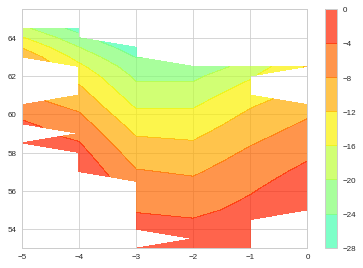

In [11]:
testDF = potentialDF[ ["mlat", "normMlt", "potential"] ].pivot( "mlat", "normMlt" )
# testDF = testDF.fillna(0.)
Y = testDF.index.values
X = testDF.columns.levels[1].values
Z=testDF.values
Xi,Yi = numpy.meshgrid(X, Y)
plt.contourf(Xi, Yi, Z, alpha=0.7, cmap=plt.cm.jet, vmin=-50, vmax=5);
plt.colorbar()

/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


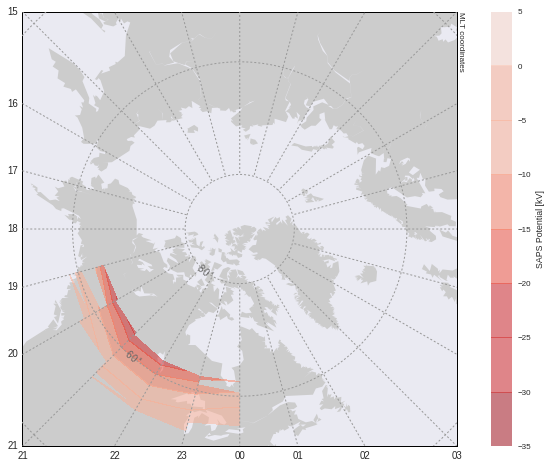

In [12]:
# seaborn color palette
seaMap = ListedColormap(sns.color_palette("Reds_r"))
sns.set_style("darkgrid")
sns.set_context("paper")
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(1,1,1)
m1 = utils.plotUtils.mapObj(boundinglat=50., gridLabels=True,\
                        coords=pltCoords, ax=ax1, lat_0=90.,\
                            lon_0=0., datetime=sapsTime)


pltDF = potentialDF[ ["mlat", "normMlt",\
                        "potential"] ].pivot( "mlat", "normMlt" )
mlatsPot = pltDF.index.values
nrmMltsPot = pltDF.columns.levels[1].values
mltsPot =[ x+24. if x < 0. else x for x in nrmMltsPot ]
potVals=pltDF.values
mltsPotCntr, mlatsPotCntr  = numpy.meshgrid( mltsPot, mlatsPot )
xVec, yVec = m1(mltsPotCntr*15., mlatsPotCntr, coords=pltCoords)
cntrPlt = m1.contourf(xVec, yVec, potVals,cntrLevels,\
    zorder = 8., alpha=0.5,\
    cmap=seaMap, ax=ax1);
cbar = plt.colorbar(cntrPlt,ticks=cntrLevels,ax=ax1)
cbar.set_clim( cntrPotMin, cntrPotMax )
cbar.ax.set_ylabel('SAPS Potential [kV]')